In [3]:
import requests
import pandas as pd
from rdkit import Chem
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

from threading import Lock, Semaphore
from functools import wraps

import cirpy

import numpy as np

from tenacity import retry, stop_after_attempt, wait_fixed, retry_if_result

In [4]:
import os
import psutil

def get_optimal_worker_count(io_bound=True):
    cpu_count = os.cpu_count()
    if cpu_count is None:
        return 4  # Default to 4 if we can't determine CPU count
    
    if io_bound:
        # For I/O bound tasks, we can use more workers
        return min(32, cpu_count * 4)
    else:
        # For CPU bound tasks, use number of CPU cores
        return cpu_count

# Usage
io_bound_workers = get_optimal_worker_count(io_bound=True)
cpu_bound_workers = get_optimal_worker_count(io_bound=False)

print(f"Recommended workers for I/O-bound tasks: {io_bound_workers}")
print(f"Recommended workers for CPU-bound tasks: {cpu_bound_workers}")

# Get more detailed system information
print(f"\nCPU cores: {psutil.cpu_count(logical=False)}")
print(f"Logical processors: {psutil.cpu_count(logical=True)}")
print(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")

Recommended workers for I/O-bound tasks: 32
Recommended workers for CPU-bound tasks: 10

CPU cores: 10
Logical processors: 10
Total RAM: 32.00 GB


In [5]:
headers = [
  "Index", "Name", "Synonym", "Structure", "Mol. form.", "CAS Reg. No.", "Beilstein Reg. No.", "Mol. wt.",
  "Physical form", "tmp/ºC", "tbp/ºC", "Other bp/ºC", "ρ/g cm-3",
  "nD", "s/g kg-1", "vp/kPa (25 °C)", "Solubility"
]
headers = [h.strip() for h in headers]
headers, len(headers)

(['Index',
  'Name',
  'Synonym',
  'Structure',
  'Mol. form.',
  'CAS Reg. No.',
  'Beilstein Reg. No.',
  'Mol. wt.',
  'Physical form',
  'tmp/ºC',
  'tbp/ºC',
  'Other bp/ºC',
  'ρ/g cm-3',
  'nD',
  's/g kg-1',
  'vp/kPa (25 °C)',
  'Solubility'],
 17)

In [ ]:
filename = 'physical_constants_of_organic_compounds_CRC_handbook_data_10902entries.csv'
df = pd.read_csv(filename, names=headers, skiprows=1, index_col='Index')
# remove structure column
df.drop(columns=['Structure'], inplace=True)
# df

In [ ]:
class RateLimiter:
    def __init__(self, max_calls, period):
        self.semaphore = Semaphore(max_calls)
        self.period = period
        self.lock = Lock()
        self.last_reset = time.time()
        self.call_count = 0

    def __call__(self, func):
        @wraps(func)
        def wrapped(*args, **kwargs):
            with self.lock:
                current_time = time.time()
                if current_time - self.last_reset >= self.period:
                    self.call_count = 0
                    self.last_reset = current_time

            with self.semaphore:
                with self.lock:
                    self.call_count += 1
                    if self.call_count >= self.semaphore._value:
                        sleep_time = self.period - (current_time - self.last_reset)
                        if sleep_time > 0:
                            time.sleep(sleep_time)
                        
                        self.call_count = 0
                        self.last_reset = time.time()
                        
                # return func(*args, **kwargs)
                result = func(*args, **kwargs)
                self.semaphore.release()
                return result
        return wrapped

def retry_if_none(result):
    return result is None

# Rest of the code remains the same
@RateLimiter(max_calls=5, period=1) # 5 requests per second is the maximum allowed by PubChem
@retry(stop=stop_after_attempt(2), wait=wait_fixed(1))  # Retry once with a 1-second wait if result is None
def get_smiles_from_cas(cas_number):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas_number}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
        return smiles
    else:
        return None
    
@RateLimiter(max_calls=5, period=1) # 5 requests per second is the maximum allowed by PubChem
@retry(stop=stop_after_attempt(2), wait=wait_fixed(1))  # Retry once with a 1-second wait if result is None
def get_smiles_from_cas_nih(cas_number):
    url = f"https://cactus.nci.nih.gov/chemical/structure/{cas_number}/smiles"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        return None

In [ ]:
def fetch_and_draw_smiles(cas_number = "3383-96-8"):
    smiles_demo = get_smiles_from_cas(cas_number)
    if smiles_demo:
        print(f"SMILES for CAS {cas_number}: {smiles_demo}")
        m = Chem.MolFromSmiles(smiles_demo)
        display(m)
        return smiles_demo
    else:
        print(f"Could not retrieve SMILES for CAS {cas_number}")
        
fetch_and_draw_smiles()

In [ ]:
# df.drop(columns=['SMILES'], inplace=True)
# df

In [ ]:
def process_cas_numbers(df, column_name, max_workers=5):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_index = {executor.submit(get_smiles_from_cas, cas): index 
                           for index, cas in df[column_name].items()}
        
        # Process results as they complete
        results = {}
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            try:
                result = future.result()
                results[index] = result
            except Exception as exc:
                print(f'CAS number at index {index} generated an exception: {exc}')
                results[index] = None
    
    return pd.Series(results)


In [ ]:
# Process the DataFrame
start_time = time.time()
smiles = process_cas_numbers(df.iloc[:25], 'CAS Reg. No.')
end_time = time.time()

print(f"Processing time: {end_time - start_time:.2f} seconds")

smiles.isnull().sum(), smiles[smiles.isnull()], smiles.__len__()

In [ ]:
smiles.iloc[0], display(Chem.MolFromSmiles(smiles.iloc[0]))

In [ ]:
# Run the original code for comparison (single-threaded)
start_time = time.time()
# smiles_old = df.iloc[:100]['CAS Reg. No.'].apply(get_smiles_from_cas)
smiles_old = df['CAS Reg. No.'].apply(get_smiles_from_cas)
end_time = time.time()

print(f"Processing time: {end_time - start_time:.2f} seconds")

smiles_old.isnull().sum(), smiles_old[smiles_old.isnull()], smiles_old.__len__()

In [ ]:
ind = 48
print(f"{ind=}: {df['SMILES'].iloc[ind]=}")
display(Chem.MolFromSmiles(df['SMILES'].iloc[ind]))
fetch_and_draw_smiles(df['CAS Reg. No.'].iloc[ind])

In [7]:
filename = 'constants_with_smiles_updated.csv'
df = pd.read_csv(filename, index_col='Index')
df

,Name,Synonym,Mol. form.,CAS Reg. No.,Beilstein Reg. No.,Mol. wt.,Physical form,tmp/ºC,tbp/ºC,Other bp/ºC,ρ/g cm-3,nD,s/g kg-1,vp/kPa (25 °C),Solubility,SMILES
Index,,,,,,,,,,,,,,,,
1,Abate,Temephos,C16H20O6P2S3,3383-96-8,NaN,466.469,cry,31.6(5),NaN,NaN,1.32,NaN,NaN,NaN,"sl H2O, hx; s ctc, eth, tol",COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...
2,Abietic acid,Sylvic acid,C20H30O2,514-10-3,2221451.0,302.451,mcl pl (al-w),173.5,439.5,2509,1.0625,NaN,NaN,NaN,"vs ace, bz, eth, EtOH",CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C
3,Abscisic acid,NaN,C15H20O4,21293-29-8,2698956.0,264.318,cry (chl-peth),160,120 subl,NaN,NaN,NaN,NaN,NaN,"vs ace, eth, chl",CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C
4,Acacetin,"5,7-Dihydroxy-2-(4-methoxyphenyl)-4H-1-benzopy...",C16H12O5,480-44-4,277879.0,284.263,ye nd (95% al),263,NaN,NaN,NaN,NaN,NaN,NaN,vs EtOH,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O
5,"Acebutolol, (±)-",NaN,C18H28N2O4,37517-30-9,NaN,336.426,cry,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,Zinc gluconate,NaN,C12H22O14Zn,4468-02-4,NaN,455.704,pow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[...
10899,"Zinc 2,4-pentanedioate",Zinc acetylacetonate,C10H14O4Zn,14024-63-6,4157976.0,263.625,cry,127.3(2),NaN,NaN,NaN,NaN,NaN,NaN,"sl H2O; s EtOH, DMSO",CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn]
10900,Zinc propanoate,NaN,C6H10O4Zn,557-28-8,NaN,211.550,hyg pl or nd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sl EtOH,CCC(=O)[O-].CCC(=O)[O-].[Zn+2]


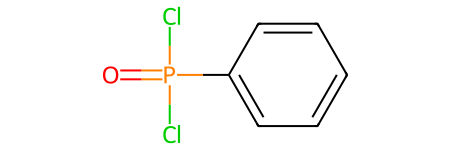

In [31]:
Chem.MolFromSmiles(df['SMILES'].at[8980])

In [ ]:
df['SMILES'][df['SMILES'].isnull()].index

In [ ]:
# random number between 0 and 10902
val = []
for _ in range(100):
    ind = np.random.randint(0, 10902)
    read_cas_number = df['CAS Reg. No.'].at[ind]
    computed_smi = get_smiles_from_cas(read_cas_number)
    read_smi = df['SMILES'].at[ind]
    temp = read_smi == computed_smi
    if not temp:
        computed_smi = cirpy.resolve(df['CAS Reg. No.'].at[ind], 'smiles')
        time.sleep(1)
        temp = read_smi == computed_smi
        print(f"{ind=}")
    val.append(temp)

print(np.array(val).all())

In [ ]:
ind = 214
df['SMILES'].at[ind], df['CAS Reg. No.'].at[ind], get_smiles_from_cas(df['CAS Reg. No.'].at[ind]), cirpy.resolve(df['CAS Reg. No.'].at[ind], 'smiles')

In [ ]:
null_indices = df['SMILES'][df['SMILES'].isnull()].index
null_indices

In [ ]:
idx = 308
get_smiles_from_cas_nih(df['CAS Reg. No.'].at[idx]), cirpy.resolve(df['CAS Reg. No.'].at[idx], 'smiles')

In [ ]:
null_indices = df['SMILES'][df['SMILES'].isnull()].index
null_indices, len(null_indices)

In [ ]:
new_smiles = []
for idx in null_indices:
    # smi = get_smiles_from_cas_nih(df['CAS Reg. No.'].at[idx])
    smi = cirpy.resolve(df['CAS Reg. No.'].at[idx], 'smiles')
    time.sleep(1)
    new_smiles.append(smi)

# new_smiles

In [ ]:
df['SMILES'].loc[null_indices] = new_smiles

In [ ]:
df.to_csv('constants_with_smiles_updated.csv')

In [ ]:
df.columns

In [ ]:
for col in ['tmp/ºC', 'tbp/ºC', 'Other bp/ºC', 'ρ/g cm-3', 'nD', 's/g kg-1', 'vp/kPa (25 °C)',  'SMILES']:
    # col = 'vp/kPa (25 °C)'
    temp = df[col][~df[col].isnull()]
    print(col, temp.__len__())

In [82]:
col = 'tmp/ºC'
df_mp = df[col][~df[col].isnull()]
df_mp

Index
1          31.6(5)
2            173.5
3              160
4              263
5              121
           ...    
10896    -33.34(2)
10897      157 dec
10899     127.3(2)
10901          250
10902          248
Name: tmp/ºC, Length: 7982, dtype: object

In [106]:
df[col].at[250]

'dec'

In [128]:
new_df = pd.DataFrame({
    'SMILES': df.loc[df_mp.index, 'SMILES'],
    'Melting point (C)': df.loc[df_mp.index, col],
}).reset_index(drop=True)

# new_df.to_csv('melting_points.csv')
# new_df.set_index('SMILES', inplace=True)
new_df

,SMILES,Melting point (C)
0,COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...,31.6(5)
1,CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C,173.5
2,CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C,160
3,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,263
4,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,121
...,...,...
7977,C[CH2-].C[CH2-].[Zn+2],-33.34(2)
7978,C(CNC(=S)[S-])NC(=S)[S-].[Zn+2],157 dec
7979,CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn],127.3(2)
7980,CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2],250


In [152]:
invalid_smi = new_df['SMILES'].isnull()
invalid_smi.sum()

0

In [151]:
new_df = new_df[~invalid_smi]
new_df

,SMILES,Melting point (C),MP (processed)
0,COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...,31.6(5),31.60
1,CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C,173.5,173.50
2,CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C,160,160.00
3,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,263,263.00
4,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,121,121.00
...,...,...,...
7976,CCCCN(CCCC)C(=S)[S-].CCCCN(CCCC)C(=S)[S-].[Zn+2],138,138.00
7977,C[CH2-].C[CH2-].[Zn+2],-33.34(2),-33.34
7979,CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn],127.3(2),127.30
7980,CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2],250,250.00


In [130]:
new_df['Melting point (C)'].isna().sum()

0

In [153]:
new_df.to_csv('melting_points_updated.csv')

In [129]:
# Extract numeric values from 'Melting point (C)' and create a new column 'MP'
new_df['MP (processed)'] = new_df['Melting point (C)'].str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)

new_df

,SMILES,Melting point (C),MP (processed)
0,COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...,31.6(5),31.60
1,CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C,173.5,173.50
2,CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C,160,160.00
3,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,263,263.00
4,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,121,121.00
...,...,...,...
7977,C[CH2-].C[CH2-].[Zn+2],-33.34(2),-33.34
7978,C(CNC(=S)[S-])NC(=S)[S-].[Zn+2],157 dec,157.00
7979,CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn],127.3(2),127.30
7980,CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2],250,250.00


In [131]:
filter_dec_keyword = new_df['Melting point (C)'].str.contains('dec', case=True, na=False)
filter_dec_keyword

0       False
1       False
2       False
3       False
4       False
        ...  
7977    False
7978     True
7979    False
7980    False
7981    False
Name: Melting point (C), Length: 7982, dtype: bool

In [ ]:
new_df = new_df[~filter_dec_keyword]
new_df

In [156]:
nan_ind = new_df['MP (processed)'].isna()
nan_ind.sum()

0

In [155]:
new_df = new_df[~nan_ind]
new_df

,SMILES,Melting point (C),MP (processed)
0,COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(...,31.6(5),31.60
1,CC(C)C1=CC2=CCC3C(C2CC1)(CCCC3(C)C(=O)O)C,173.5,173.50
2,CC1=CC(=O)CC(C1(C=CC(=CC(=O)O)C)O)(C)C,160,160.00
3,COC1=CC=C(C=C1)C2=CC(=O)C3=C(C=C(C=C3O2)O)O,263,263.00
4,CCCC(=O)NC1=CC(=C(C=C1)OCC(CNC(C)C)O)C(=O)C,121,121.00
...,...,...,...
7976,CCCCN(CCCC)C(=S)[S-].CCCCN(CCCC)C(=S)[S-].[Zn+2],138,138.00
7977,C[CH2-].C[CH2-].[Zn+2],-33.34(2),-33.34
7979,CC(=CC(=O)C)O.CC(=CC(=O)C)O.[Zn],127.3(2),127.30
7980,CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2],250,250.00


In [157]:
new_df['MP (processed)'][new_df['MP (processed)'].isna()]

Series([], Name: MP (processed), dtype: float64)

In [160]:
new_df['MP (processed)'][new_df['MP (processed)'] == 0]

523     0.0
1803    0.0
3615    0.0
3662    0.0
3760    0.0
4966    0.0
6057    0.0
6105    0.0
7128    0.0
7867    0.0
Name: MP (processed), dtype: float64

In [162]:
new_df['MP (processed)'].at[523], new_df['Melting point (C)'].at[523]

(0.0, '<0')

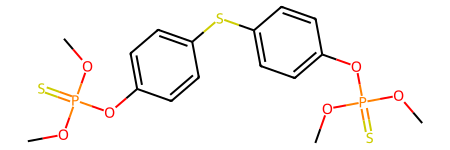

('COP(=S)(OC)OC1=CC=C(C=C1)SC2=CC=C(C=C2)OP(=S)(OC)OC', 31.6)

In [172]:
idx = 0
display(Chem.MolFromSmiles(new_df['SMILES'].at[idx]))
new_df['SMILES'].at[idx], new_df['MP (processed)'].at[idx]